# Week 6 - Classification

This week, we shift from gathering human textual classifications through crowdsourcing, to using machine learning models and algorithms that train on those human classifications and extend them to documents far too numerous to read. If you recall, *clustering* allows us to stably partition text data (e.g., documents, turns of conversation) according to all patterns of covariation among available text features. *Classification*, by contrast, partitions text data according to only those features and their variation that enable us to mimic and extrapolate human annotations.

In this notebook, we will show how to use a variety of classification methods, including Naïve Bayes, Logistic regression, K-nearest neighbor, decision trees and random forests, support vector machines and even a simple neural network, the perceptron. We will also demonstrate ensemble techniques that can link several such methods into a single, more accurate, classification pipeline. We will finally learn to use conventions and metrics to evaluate classifier performance on out-of-sample data. 

For this notebook we will be using the following packages.

In [1]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud #pip install -U git+git://github.com/Computational-Content-Analysis-2018/lucem_illud.git

#All these packages need to be installed from pip
#For ML
import sklearn
import sklearn.naive_bayes
import sklearn.tree
import sklearn.ensemble
import sklearn.neural_network
import sklearn.decomposition

import nltk #For tokenizing and normalizing
import numpy as np #arrays
import matplotlib.pyplot as plt #Plots
import matplotlib.colors # For nice colours
import seaborn #Makes plots look nice, also heatmaps
import scipy as sp #for interp

#These are from the standard library
import collections
import os
import os.path
import random
import re
import glob
import pandas
import requests
import json
import math

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

D:\computation\Anaconda3\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


# Simple Simulated Examples

Here we create a sandbox for you to explore different types of classified data and how different statistical classifiers perform on each type.

## Generating example data

We start by loading one of the "cartoon" or simplified data sets and then dividing it into training and testing sets. To maximize our ability to visualize, each dataset involves two classes, colored yellow and blue, arrayed along two two dimensions (`x` and `y`). 

The four data patterns include: 
+ `random` in which the two classes are randomly distributed across both dimensions
+ `andSplit` in which the two classes are linearly split along one of two dimensions (e.g., men like Adidas)
+ `xorSplit` in which the two classes are split, oppositely, along each dimension (e.g., old ladies and young men like Nikes)
+ `targetSplit` in which one class is nested within the other in two dimensions (e.g., middle aged, middle income people like vintage Mustangs)
+ `multiBlobs` in which 5 classes are placed as bivariate Gaussians at random locations

`noise` is a variable [0-1] that ranges from no noise in the prescribed pattern [0] to complete noise/randomness [1].

Uncomment (remove the # in front of) each dataset, one at a time, and then run the cell and subsequent cells to examine how each machine learning approach captures each pattern.

Below, I create 5 distinct datasets, then classify each one with all methods.

Although the Exercise technically calls for ten distinct sets, in the interest of time I have limited myself to five.

In [34]:
# five distinct datasets

noise = .2

dfTrain, dfTest = lucem_illud.trainTestSplit(lucem_illud.random())
dfTrain1, dfTest1 = lucem_illud.trainTestSplit(lucem_illud.andSplit(noise))
dfTrain2, dfTest2 = lucem_illud.trainTestSplit(lucem_illud.xorSplit(noise))
dfTrain3, dfTest3 = lucem_illud.trainTestSplit(lucem_illud.targetSplit(noise))
dfTrain4, dfTest4 = lucem_illud.trainTestSplit(lucem_illud.multiBlobs(noise))

Available methods - copy/pasted from below. 

In [35]:
#Bayes
clfBayes = sklearn.naive_bayes.GaussianNB()

#Analogizes
clfLinear = sklearn.svm.SVC(kernel = 'linear', probability = True) #slow, set probability = False to speed up
clfKernel = sklearn.svm.SVC(kernel = 'poly', degree = 3, probability = True) #slower
clfKNeighbors = sklearn.neighbors.KNeighborsClassifier(5, weights='distance')# k, 'distance' or 'uniform'

#Classical Regression
clfReg = sklearn.linear_model.LogisticRegression()

#Symbolists
clfTree = sklearn.tree.DecisionTreeClassifier()
clfForest = sklearn.ensemble.RandomForestClassifier()

#Connectionists
clfNN = sklearn.neural_network.MLPClassifier()

#Ensemble
clfEnsem = sklearn.ensemble.GradientBoostingClassifier()

To make things easy, I am only going to run each through the evaluateClassifier function.

In [36]:
#dataset 1 - random!

clfBayes.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])
clfLinear.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])
clfKernel.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])
clfKNeighbors.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])
clfReg.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])
clfTree.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])
clfForest.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])
clfNN.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])
clfEnsem.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])

print("Bayes")
display(lucem_illud.evaluateClassifier(clfBayes, dfTest))
print("Linear")
display(lucem_illud.evaluateClassifier(clfLinear, dfTest))
print("Multi")
display(lucem_illud.evaluateClassifier(clfKernel, dfTest))
print("k-neighbores")
display(lucem_illud.evaluateClassifier(clfKNeighbors, dfTest))
print("regression")
display(lucem_illud.evaluateClassifier(clfReg, dfTest))
print("tree")
display(lucem_illud.evaluateClassifier(clfTree, dfTest))
print("forest")
display(lucem_illud.evaluateClassifier(clfForest, dfTest))
print("neural net")
display(lucem_illud.evaluateClassifier(clfNN, dfTest))
print("ensemble")
display(lucem_illud.evaluateClassifier(clfEnsem, dfTest))

Bayes


,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
0,0.464896,0.488646,0.535,0.470588,0.475248
1,0.464896,0.478720,0.535,0.459184,0.454545


Linear


,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
0,0.545405,0.529918,0.455,0.554348,0.504950
1,0.545405,0.519628,0.455,0.537037,0.585859


Multi


,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
0,0.494799,0.502426,0.505,0.500000,0.514851
1,0.494799,0.492428,0.505,0.489583,0.474747


k-neighbores


,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
0,0.435194,0.476931,0.565,0.437500,0.415842
1,0.435194,0.466678,0.565,0.432692,0.454545


regression


,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
0,0.535704,0.524317,0.465,0.546512,0.465347
1,0.535704,0.513979,0.465,0.526316,0.606061


tree


,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
0,0.425093,0.473218,0.575,0.428571,0.415842
1,0.425093,0.463106,0.575,0.421569,0.434343


forest


,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
0,0.454895,0.484424,0.545,0.460784,0.465347
1,0.454895,0.474546,0.545,0.448980,0.444444


neural net


,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
0,0.515502,0.513014,0.485,0.522222,0.465347
1,0.515502,0.502971,0.485,0.509091,0.565657


ensemble


,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
0,0.480048,0.495423,0.52,0.484848,0.475248
1,0.480048,0.485423,0.52,0.475248,0.484848


In [37]:
#dataset 2 - andSplit

clfBayes.fit(np.stack(dfTrain1['vect'], axis=0), dfTrain1['category'])
clfLinear.fit(np.stack(dfTrain1['vect'], axis=0), dfTrain1['category'])
clfKernel.fit(np.stack(dfTrain1['vect'], axis=0), dfTrain1['category'])
clfKNeighbors.fit(np.stack(dfTrain1['vect'], axis=0), dfTrain1['category'])
clfReg.fit(np.stack(dfTrain1['vect'], axis=0), dfTrain1['category'])
clfTree.fit(np.stack(dfTrain1['vect'], axis=0), dfTrain1['category'])
clfForest.fit(np.stack(dfTrain1['vect'], axis=0), dfTrain1['category'])
clfNN.fit(np.stack(dfTrain1['vect'], axis=0), dfTrain1['category'])
clfEnsem.fit(np.stack(dfTrain1['vect'], axis=0), dfTrain1['category'])

print("Bayes")
display(lucem_illud.evaluateClassifier(clfBayes, dfTest1))
print("Linear")
display(lucem_illud.evaluateClassifier(clfLinear, dfTest1))
print("Multi")
display(lucem_illud.evaluateClassifier(clfKernel, dfTest1))
print("k-neighbores")
display(lucem_illud.evaluateClassifier(clfKNeighbors, dfTest1))
print("regression")
display(lucem_illud.evaluateClassifier(clfReg, dfTest1))
print("tree")
display(lucem_illud.evaluateClassifier(clfTree, dfTest1))
print("forest")
display(lucem_illud.evaluateClassifier(clfForest, dfTest1))
print("neural net")
display(lucem_illud.evaluateClassifier(clfNN, dfTest1))
print("ensemble")
display(lucem_illud.evaluateClassifier(clfEnsem, dfTest1))

Bayes


,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
0,0.889,0.855031,0.11,0.888889,0.90566
1,0.889,0.837521,0.11,0.891304,0.87234


Linear


,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
0,0.878362,0.840395,0.12,0.872727,0.905660
1,0.878362,0.826501,0.12,0.888889,0.851064


Multi


,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
0,0.889603,0.858222,0.11,0.896226,0.896226
1,0.889603,0.834651,0.11,0.882979,0.882979


k-neighbores


,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
0,0.904958,0.878032,0.095,0.914286,0.905660
1,0.904958,0.854071,0.095,0.894737,0.904255


regression


,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
0,0.889,0.855031,0.11,0.888889,0.90566
1,0.889,0.837521,0.11,0.891304,0.87234


tree


,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
0,0.874849,0.842089,0.125,0.885714,0.877358
1,0.874849,0.812968,0.125,0.863158,0.872340


forest


,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
0,0.903754,0.871227,0.095,0.899083,0.924528
1,0.903754,0.860354,0.095,0.912088,0.882979


neural net


,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
0,0.889,0.855031,0.11,0.888889,0.90566
1,0.889,0.837521,0.11,0.891304,0.87234


ensemble


,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
0,0.887796,0.848962,0.11,0.875000,0.924528
1,0.887796,0.843694,0.11,0.909091,0.851064


In [38]:
#dataset 3 - xorsplit!

clfBayes.fit(np.stack(dfTrain2['vect'], axis=0), dfTrain2['category'])
clfLinear.fit(np.stack(dfTrain2['vect'], axis=0), dfTrain2['category'])
clfKernel.fit(np.stack(dfTrain2['vect'], axis=0), dfTrain2['category'])
clfKNeighbors.fit(np.stack(dfTrain2['vect'], axis=0), dfTrain2['category'])
clfReg.fit(np.stack(dfTrain2['vect'], axis=0), dfTrain2['category'])
clfTree.fit(np.stack(dfTrain2['vect'], axis=0), dfTrain2['category'])
clfForest.fit(np.stack(dfTrain2['vect'], axis=0), dfTrain2['category'])
clfNN.fit(np.stack(dfTrain2['vect'], axis=0), dfTrain2['category'])
clfEnsem.fit(np.stack(dfTrain2['vect'], axis=0), dfTrain2['category'])

display(lucem_illud.evaluateClassifier(clfBayes, dfTest2))
display(lucem_illud.evaluateClassifier(clfLinear, dfTest2))
display(lucem_illud.evaluateClassifier(clfKernel, dfTest2))
display(lucem_illud.evaluateClassifier(clfKNeighbors, dfTest2))
display(lucem_illud.evaluateClassifier(clfReg, dfTest2))
display(lucem_illud.evaluateClassifier(clfTree, dfTest2))
display(lucem_illud.evaluateClassifier(clfForest, dfTest2))
display(lucem_illud.evaluateClassifier(clfNN, dfTest2))
display(lucem_illud.evaluateClassifier(clfEnsem, dfTest2))

D:\computation\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
0,0.518607,0.499710,0.48,0.511628,0.448980
1,0.518607,0.519598,0.48,0.526316,0.588235


,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
0,0.55082,0.517838,0.45,0.537037,0.591837
1,0.55082,0.538150,0.45,0.565217,0.509804


,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
0,0.685274,0.649906,0.31,0.846154,0.448980
1,0.685274,0.625321,0.31,0.635135,0.921569


,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
0,0.895458,0.842457,0.105,0.873786,0.918367
1,0.895458,0.865586,0.105,0.917526,0.872549


,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
0,0.509804,0.495000,0.49,0.500000,0.500000
1,0.509804,0.514992,0.49,0.519608,0.519608


,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
0,0.880152,0.827347,0.12,0.87,0.887755
1,0.880152,0.841569,0.12,0.89,0.872549


,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
0,0.885654,0.827172,0.115,0.857143,0.918367
1,0.885654,0.856115,0.115,0.915789,0.852941


,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
0,0.90016,0.853265,0.1,0.89,0.908163
1,0.90016,0.866863,0.1,0.91,0.892157


,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
0,0.880352,0.82471,0.12,0.862745,0.897959
1,0.880352,0.84471,0.12,0.897959,0.862745


In [39]:
#dataset 4 - targetsplit!

clfBayes.fit(np.stack(dfTrain3['vect'], axis=0), dfTrain3['category'])
clfLinear.fit(np.stack(dfTrain3['vect'], axis=0), dfTrain3['category'])
clfKernel.fit(np.stack(dfTrain3['vect'], axis=0), dfTrain3['category'])
clfKNeighbors.fit(np.stack(dfTrain3['vect'], axis=0), dfTrain3['category'])
clfReg.fit(np.stack(dfTrain3['vect'], axis=0), dfTrain3['category'])
clfTree.fit(np.stack(dfTrain3['vect'], axis=0), dfTrain3['category'])
clfForest.fit(np.stack(dfTrain3['vect'], axis=0), dfTrain3['category'])
clfNN.fit(np.stack(dfTrain3['vect'], axis=0), dfTrain3['category'])
clfEnsem.fit(np.stack(dfTrain3['vect'], axis=0), dfTrain3['category'])

display(lucem_illud.evaluateClassifier(clfBayes, dfTest3))
display(lucem_illud.evaluateClassifier(clfLinear, dfTest3))
display(lucem_illud.evaluateClassifier(clfKernel, dfTest3))
display(lucem_illud.evaluateClassifier(clfKNeighbors, dfTest3))
display(lucem_illud.evaluateClassifier(clfReg, dfTest3))
display(lucem_illud.evaluateClassifier(clfTree, dfTest3))
display(lucem_illud.evaluateClassifier(clfForest, dfTest3))
display(lucem_illud.evaluateClassifier(clfNN, dfTest3))
display(lucem_illud.evaluateClassifier(clfEnsem, dfTest3))

D:\computation\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
0,0.909105,0.836668,0.095,0.849057,0.967742
1,0.909105,0.903325,0.095,0.968085,0.850467


,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
0,0.617978,0.532737,0.405,0.536585,0.946237
1,0.617978,0.629481,0.405,0.861111,0.289720


D:\computation\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
0,0.5,0.465,0.535,0.465,1.0
1,0.5,0.535,0.535,0.000,0.0


,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
0,0.868908,0.785254,0.135,0.811321,0.924731
1,0.868908,0.852535,0.135,0.925532,0.813084


,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
0,0.586624,0.514153,0.425,0.530303,0.752688
1,0.586624,0.588312,0.425,0.661765,0.420561


,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
0,0.83268,0.744936,0.17,0.786408,0.870968
1,0.83268,0.806117,0.17,0.876289,0.794393


,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
0,0.854186,0.766058,0.15,0.794393,0.913978
1,0.854186,0.836058,0.15,0.913978,0.794393


,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
0,0.889006,0.810555,0.115,0.830189,0.946237
1,0.889006,0.877532,0.115,0.946809,0.831776


,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
0,0.858155,0.774529,0.145,0.807692,0.903226
1,0.858155,0.836857,0.145,0.906250,0.813084


In [40]:
#dataset 5 - multiBlobs! 

clfBayes.fit(np.stack(dfTrain4['vect'], axis=0), dfTrain4['category'])
clfLinear.fit(np.stack(dfTrain4['vect'], axis=0), dfTrain4['category'])
clfKernel.fit(np.stack(dfTrain4['vect'], axis=0), dfTrain4['category'])
clfKNeighbors.fit(np.stack(dfTrain4['vect'], axis=0), dfTrain4['category'])
clfReg.fit(np.stack(dfTrain4['vect'], axis=0), dfTrain4['category'])
clfTree.fit(np.stack(dfTrain4['vect'], axis=0), dfTrain4['category'])
clfForest.fit(np.stack(dfTrain4['vect'], axis=0), dfTrain4['category'])
clfNN.fit(np.stack(dfTrain4['vect'], axis=0), dfTrain4['category'])
clfEnsem.fit(np.stack(dfTrain4['vect'], axis=0), dfTrain4['category'])

display(lucem_illud.evaluateClassifier(clfBayes, dfTest4))
display(lucem_illud.evaluateClassifier(clfLinear, dfTest4))
display(lucem_illud.evaluateClassifier(clfKernel, dfTest4))
display(lucem_illud.evaluateClassifier(clfKNeighbors, dfTest4))
display(lucem_illud.evaluateClassifier(clfReg, dfTest4))
display(lucem_illud.evaluateClassifier(clfTree, dfTest4))
display(lucem_illud.evaluateClassifier(clfForest, dfTest4))
display(lucem_illud.evaluateClassifier(clfNN, dfTest4))
display(lucem_illud.evaluateClassifier(clfEnsem, dfTest4))

,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
0,0.996250,0.970874,0.006,0.970874,1.000000
1,1.000000,1.000000,0.000,1.000000,1.000000
2,1.000000,1.000000,0.000,1.000000,1.000000
3,1.000000,1.000000,0.000,1.000000,1.000000
4,0.985849,0.977698,0.006,1.000000,0.971698


,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
0,0.997500,0.980392,0.004,0.980392,1.000000
1,0.997531,0.979381,0.004,0.979381,1.000000
2,1.000000,1.000000,0.000,1.000000,1.000000
3,1.000000,1.000000,0.000,1.000000,1.000000
4,0.981132,0.970264,0.008,1.000000,0.962264


,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
0,0.997500,0.980392,0.004,0.980392,1.000000
1,0.998765,0.989583,0.002,0.989583,1.000000
2,1.000000,1.000000,0.000,1.000000,1.000000
3,1.000000,1.000000,0.000,1.000000,1.000000
4,0.985849,0.977698,0.006,1.000000,0.971698


,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
0,0.997500,0.980392,0.004,0.980392,1.000000
1,1.000000,1.000000,0.000,1.000000,1.000000
2,0.998775,0.989247,0.002,0.989247,1.000000
3,0.995327,0.992654,0.002,1.000000,0.990654
4,0.990566,0.985132,0.004,1.000000,0.981132


,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
0,0.991250,0.934579,0.014,0.934579,1.000000
1,0.997531,0.979381,0.004,0.979381,1.000000
2,0.998775,0.989247,0.002,0.989247,1.000000
3,0.995327,0.992654,0.002,1.000000,0.990654
4,0.957547,0.933094,0.018,1.000000,0.915094


,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
0,0.995000,0.961538,0.008,0.961538,1.000000
1,1.000000,1.000000,0.000,1.000000,1.000000
2,0.994565,0.991130,0.002,1.000000,0.989130
3,0.998728,0.990741,0.002,0.990741,1.000000
4,0.981132,0.970264,0.008,1.000000,0.962264


,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
0,0.993750,0.952381,0.010,0.952381,1.000000
1,0.994737,0.991474,0.002,1.000000,0.989474
2,1.000000,1.000000,0.000,1.000000,1.000000
3,1.000000,1.000000,0.000,1.000000,1.000000
4,0.981132,0.970264,0.008,1.000000,0.962264


,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
0,0.99125,0.962882,0.008,0.970588,0.990000
1,1.00000,1.000000,0.000,1.000000,1.000000
2,1.00000,1.000000,0.000,1.000000,1.000000
3,1.00000,1.000000,0.000,1.000000,1.000000
4,0.98458,0.968355,0.008,0.990385,0.971698


,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
0,0.995000,0.961538,0.008,0.961538,1.000000
1,1.000000,1.000000,0.000,1.000000,1.000000
2,1.000000,1.000000,0.000,1.000000,1.000000
3,1.000000,1.000000,0.000,1.000000,1.000000
4,0.981132,0.970264,0.008,1.000000,0.962264


We can easily visualize the rendered datasets because they are generated in two dimensions.

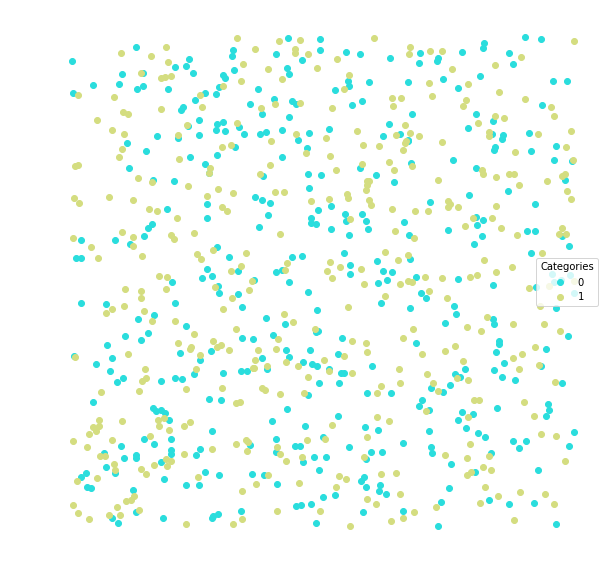

In [41]:
lucem_illud.plotter(dfTrain)

## Training a Machine Learning algorithm

We can now pick a model, there are many more options in `scikit-learn`. These are just a few examples, which array along the machine learning "tribes" described in Pedro Domingos _The Master Algorithm_.

Uncomment (remove the # in front of) each algorithm one at a time, then run the cell and subsequent cells to evaluate how it learns to understand the data.

In [42]:
#Bayes
clf = sklearn.naive_bayes.GaussianNB()

#Analogizes
#clf = sklearn.svm.SVC(kernel = 'linear', probability = True) #slow, set probability = False to speed up
#clf = sklearn.svm.SVC(kernel = 'poly', degree = 3, probability = True) #slower
#clf = sklearn.neighbors.KNeighborsClassifier(5, weights='distance')# k, 'distance' or 'uniform'

#Classical Regression
#clf = sklearn.linear_model.LogisticRegression()

#Symbolists
#clf = sklearn.tree.DecisionTreeClassifier()
#clf = sklearn.ensemble.RandomForestClassifier()

#Connectionists
#clf = sklearn.neural_network.MLPClassifier()

#Ensemble
#clf = sklearn.ensemble.GradientBoostingClassifier()

Now we fit the model by giving it our training data

In [43]:
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])

GaussianNB(priors=None)

## Algorithm evaluation

We can look at few measurements of each classifier's performance by using the testing set

In [44]:
lucem_illud.evaluateClassifier(clf, dfTest)

,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
0,0.464896,0.488646,0.535,0.470588,0.475248
1,0.464896,0.478720,0.535,0.459184,0.454545


This lets us look at which classes do better:

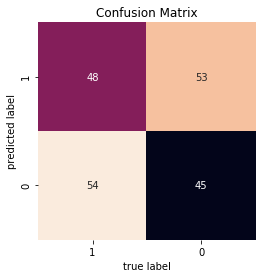

In [45]:
lucem_illud.plotConfusionMatrix(clf, dfTest)

The greater the area under the curve the better.

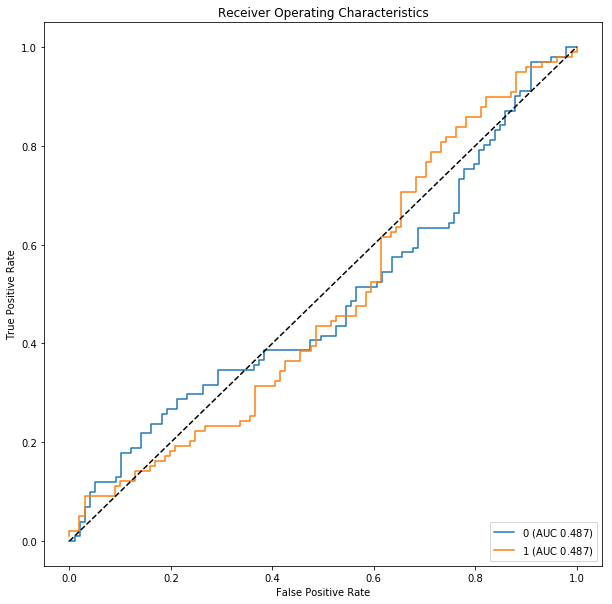

In [46]:
lucem_illud.plotMultiROC(clf, dfTest)

We can also look at the regions the classifer identifies as one class or the other:

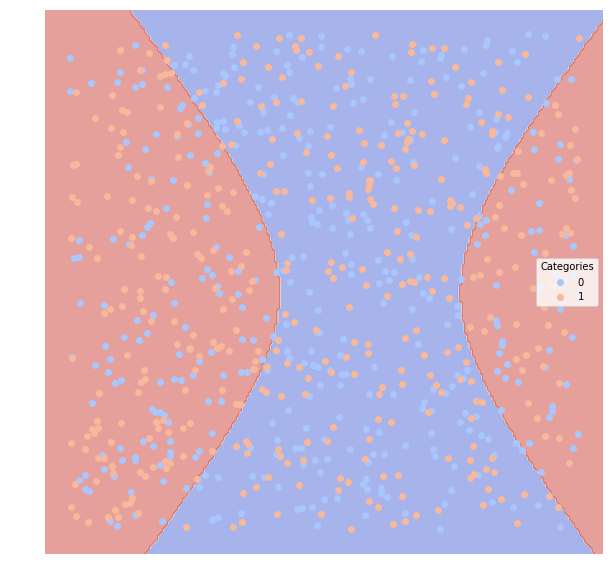

In [47]:
lucem_illud.plotregions(clf, dfTrain)

## Now we do the same for real data

Available data sets include:
+ Reddit threads "classified" by thread topic
+ 20 newsgroups "classified" by group topic
+ Senate press releases "classified" by Senator (2 senators)
+ Senate press releases "classified" by Senator (5 senators)
+ Emails classified as Spam or Ham

In [48]:
redditTrain, redditTest = lucem_illud.trainTestSplit(lucem_illud.loadReddit())
newsTrain, newsTest = lucem_illud.trainTestSplit(lucem_illud.loadNewsGroups())
senSmTrain, senSmTest = lucem_illud.trainTestSplit(lucem_illud.loadSenateSmall())
senLgTrain, senLgTest = lucem_illud.trainTestSplit(lucem_illud.loadSenateLarge())
spamTrain, spamTest = lucem_illud.trainTestSplit(lucem_illud.loadSpam())

Loading Reddit data
Converting to vectors
Loading data for: comp.sys.mac.hardware
Loading data for: comp.windows.x
Loading data for: misc.forsale
Loading data for: rec.autos
Converting to vectors
Loading senate data
Converting to vectors
Loading senator: Kennedy
Loading senator: Kerry
Loading senator: Klobuchar
Loading senator: Kohl
Loading senator: Kyl
Converting to vectors
Loading Spam
Loading Ham
Converting to vectors


Below, I pull each dataset through each classification method. Again, in the interest of time, I'm only going to run them through the evaluateClassifier function.

In [49]:
# reddit

clfBayes.fit(np.stack(redditTrain['vect'], axis=0), redditTrain['category'])
clfLinear.fit(np.stack(redditTrain['vect'], axis=0), redditTrain['category'])
clfKernel.fit(np.stack(redditTrain['vect'], axis=0), redditTrain['category'])
clfKNeighbors.fit(np.stack(redditTrain['vect'], axis=0), redditTrain['category'])
clfReg.fit(np.stack(redditTrain['vect'], axis=0), redditTrain['category'])
clfTree.fit(np.stack(redditTrain['vect'], axis=0), redditTrain['category'])
clfForest.fit(np.stack(redditTrain['vect'], axis=0), redditTrain['category'])
clfNN.fit(np.stack(redditTrain['vect'], axis=0), redditTrain['category'])
clfEnsem.fit(np.stack(redditTrain['vect'], axis=0), redditTrain['category'])

display(lucem_illud.evaluateClassifier(clfBayes, redditTest))
display(lucem_illud.evaluateClassifier(clfLinear, redditTest))
display(lucem_illud.evaluateClassifier(clfKernel, redditTest))
display(lucem_illud.evaluateClassifier(clfKNeighbors, redditTest))
display(lucem_illud.evaluateClassifier(clfReg, redditTest))
display(lucem_illud.evaluateClassifier(clfTree, redditTest))
display(lucem_illud.evaluateClassifier(clfForest, redditTest))
display(lucem_illud.evaluateClassifier(clfNN, redditTest))
display(lucem_illud.evaluateClassifier(clfEnsem, redditTest))

,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
Bad Roommates,0.761612,0.466731,0.178683,0.594937,0.652778
Weeaboo Tales,0.852125,0.536841,0.197492,0.553030,0.948052
Relationships,0.633621,0.414556,0.219436,0.729730,0.310345
Tales From Tech Support,0.903283,0.831682,0.056426,0.957746,0.819277


,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
Bad Roommates,0.969917,0.878777,0.031348,0.897436,0.972222
Weeaboo Tales,1.000000,1.000000,0.000000,1.000000,1.000000
Relationships,0.943247,0.879074,0.040752,0.940476,0.908046
Tales From Tech Support,0.973785,0.952449,0.015674,0.987500,0.951807


D:\computation\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
Bad Roommates,0.5,0.225705,0.774295,0.225705,1.0
Weeaboo Tales,0.5,0.241379,0.241379,0.000000,0.0
Relationships,0.5,0.272727,0.272727,0.000000,0.0
Tales From Tech Support,0.5,0.260188,0.260188,0.000000,0.0


,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
Bad Roommates,0.917848,0.722297,0.081505,0.767442,0.916667
Weeaboo Tales,0.925030,0.818370,0.053292,0.894737,0.883117
Relationships,0.859195,0.715831,0.100313,0.848101,0.770115
Tales From Tech Support,0.937309,0.874058,0.040752,0.948718,0.891566


,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
Bad Roommates,0.960948,0.857161,0.037618,0.884615,0.958333
Weeaboo Tales,0.978453,0.957629,0.012539,0.986667,0.961039
Relationships,0.941092,0.869027,0.043887,0.929412,0.908046
Tales From Tech Support,0.979809,0.961360,0.012539,0.987654,0.963855


,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
Bad Roommates,0.887455,0.731427,0.075235,0.842857,0.819444
Weeaboo Tales,0.902007,0.733742,0.081505,0.807229,0.870130
Relationships,0.835489,0.668056,0.119122,0.810127,0.735632
Tales From Tech Support,0.934526,0.821833,0.056426,0.873563,0.915663


,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
Bad Roommates,0.903087,0.717276,0.081505,0.787500,0.875000
Weeaboo Tales,0.950708,0.880224,0.034483,0.934211,0.922078
Relationships,0.859195,0.715831,0.100313,0.848101,0.770115
Tales From Tech Support,0.949025,0.869210,0.040752,0.916667,0.927711


,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
Bad Roommates,0.962972,0.868171,0.034483,0.896104,0.958333
Weeaboo Tales,0.991440,0.977329,0.006270,0.987013,0.987013
Relationships,0.953305,0.908247,0.031348,0.963855,0.919540
Tales From Tech Support,0.985833,0.970272,0.009404,0.987805,0.975904


,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
Bad Roommates,0.948212,0.870921,0.034483,0.929577,0.916667
Weeaboo Tales,0.972255,0.921159,0.021944,0.948718,0.961039
Relationships,0.946839,0.877330,0.040752,0.930233,0.919540
Tales From Tech Support,0.981596,0.947320,0.015674,0.964286,0.975904


In [50]:
# news 

clfBayes.fit(np.stack(newsTrain['vect'], axis=0), newsTrain['category'])
clfLinear.fit(np.stack(newsTrain['vect'], axis=0), newsTrain['category'])
clfKernel.fit(np.stack(newsTrain['vect'], axis=0), newsTrain['category'])
clfKNeighbors.fit(np.stack(newsTrain['vect'], axis=0), newsTrain['category'])
clfReg.fit(np.stack(newsTrain['vect'], axis=0), newsTrain['category'])
clfTree.fit(np.stack(newsTrain['vect'], axis=0), newsTrain['category'])
clfForest.fit(np.stack(newsTrain['vect'], axis=0), newsTrain['category'])
clfNN.fit(np.stack(newsTrain['vect'], axis=0), newsTrain['category'])
clfEnsem.fit(np.stack(newsTrain['vect'], axis=0), newsTrain['category'])

display(lucem_illud.evaluateClassifier(clfBayes, newsTest))
display(lucem_illud.evaluateClassifier(clfLinear, newsTest))
display(lucem_illud.evaluateClassifier(clfKernel, newsTest))
display(lucem_illud.evaluateClassifier(clfKNeighbors, newsTest))
display(lucem_illud.evaluateClassifier(clfReg, newsTest))
display(lucem_illud.evaluateClassifier(clfTree, newsTest))
display(lucem_illud.evaluateClassifier(clfForest, newsTest))
display(lucem_illud.evaluateClassifier(clfNN, newsTest))
display(lucem_illud.evaluateClassifier(clfEnsem, newsTest))

,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
comp.windows.x,0.906100,0.811300,0.063830,0.913793,0.841270
comp.sys.mac.hardware,0.829447,0.575341,0.153191,0.659574,0.794872
misc.forsale,0.778400,0.514718,0.146809,0.676768,0.644231
rec.autos,0.853295,0.691855,0.104255,0.824561,0.764228


,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
comp.windows.x,0.928848,0.853644,0.048936,0.932773,0.880952
comp.sys.mac.hardware,0.894700,0.767047,0.072340,0.873874,0.829060
misc.forsale,0.908759,0.771366,0.061702,0.864078,0.855769
rec.autos,0.930273,0.790379,0.068085,0.832117,0.926829


D:\computation\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
comp.windows.x,0.5,0.268085,0.268085,0.000000,0.0
comp.sys.mac.hardware,0.5,0.248936,0.248936,0.000000,0.0
misc.forsale,0.5,0.221277,0.778723,0.221277,1.0
rec.autos,0.5,0.261702,0.261702,0.000000,0.0


,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
comp.windows.x,0.563492,0.361027,0.234043,1.000000,0.126984
comp.sys.mac.hardware,0.511053,0.253247,0.434043,0.259669,0.401709
misc.forsale,0.535992,0.239622,0.261702,0.327273,0.173077
rec.autos,0.505225,0.263755,0.478723,0.266055,0.471545


,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
comp.windows.x,0.939300,0.864092,0.044681,0.926829,0.904762
comp.sys.mac.hardware,0.904639,0.800476,0.061702,0.907407,0.837607
misc.forsale,0.905317,0.771286,0.061702,0.871287,0.846154
rec.autos,0.939844,0.807635,0.061702,0.840580,0.943089


,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
comp.windows.x,0.849368,0.694264,0.106383,0.833333,0.753968
comp.sys.mac.hardware,0.779509,0.531255,0.163830,0.672414,0.666667
misc.forsale,0.803752,0.573568,0.123404,0.744681,0.673077
rec.autos,0.823704,0.579264,0.159574,0.664384,0.788618


,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
comp.windows.x,0.905316,0.784842,0.072340,0.870968,0.857143
comp.sys.mac.hardware,0.823588,0.614564,0.127660,0.752212,0.726496
misc.forsale,0.882645,0.741948,0.070213,0.873684,0.798077
rec.autos,0.846243,0.628476,0.134043,0.717391,0.804878


,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
comp.windows.x,0.946175,0.883735,0.038298,0.942623,0.912698
comp.sys.mac.hardware,0.891867,0.754224,0.076596,0.858407,0.829060
misc.forsale,0.899144,0.756753,0.065957,0.861386,0.836538
rec.autos,0.929090,0.796001,0.065957,0.843284,0.918699


,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
comp.windows.x,0.898440,0.767346,0.078723,0.856000,0.849206
comp.sys.mac.hardware,0.843515,0.648278,0.114894,0.773913,0.760684
misc.forsale,0.873082,0.694096,0.085106,0.813725,0.798077
rec.autos,0.882676,0.716397,0.095745,0.804688,0.837398


In [51]:
# Senate Small 

clfBayes.fit(np.stack(senSmTrain['vect'], axis=0), senSmTrain['category'])
clfLinear.fit(np.stack(senSmTrain['vect'], axis=0), senSmTrain['category'])
clfKernel.fit(np.stack(senSmTrain['vect'], axis=0), senSmTrain['category'])
clfKNeighbors.fit(np.stack(senSmTrain['vect'], axis=0), senSmTrain['category'])
clfReg.fit(np.stack(senSmTrain['vect'], axis=0), senSmTrain['category'])
clfTree.fit(np.stack(senSmTrain['vect'], axis=0), senSmTrain['category'])
clfForest.fit(np.stack(senSmTrain['vect'], axis=0), senSmTrain['category'])
clfNN.fit(np.stack(senSmTrain['vect'], axis=0), senSmTrain['category'])
clfEnsem.fit(np.stack(senSmTrain['vect'], axis=0), senSmTrain['category'])

display(lucem_illud.evaluateClassifier(clfBayes, senSmTest))
display(lucem_illud.evaluateClassifier(clfLinear, senSmTest))
display(lucem_illud.evaluateClassifier(clfKernel, senSmTest))
display(lucem_illud.evaluateClassifier(clfKNeighbors, senSmTest))
display(lucem_illud.evaluateClassifier(clfReg, senSmTest))
display(lucem_illud.evaluateClassifier(clfTree, senSmTest))
display(lucem_illud.evaluateClassifier(clfForest, senSmTest))
display(lucem_illud.evaluateClassifier(clfNN, senSmTest))
display(lucem_illud.evaluateClassifier(clfEnsem, senSmTest))

,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
Obama,0.821816,0.715715,0.175953,0.785235,0.806897
Clinton,0.821816,0.808553,0.175953,0.854167,0.836735


,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
Obama,0.983656,0.977296,0.014663,0.992958,0.972414
Clinton,0.983656,0.977833,0.014663,0.979899,0.994898


D:\computation\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
Obama,0.5,0.42522,0.42522,0.00000,0.0
Clinton,0.5,0.57478,0.42522,0.57478,1.0


,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
Obama,0.870567,0.789085,0.1261,0.854167,0.848276
Clinton,0.870567,0.854731,0.1261,0.888325,0.892857


,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
Obama,0.975862,0.972252,0.020528,1.000000,0.951724
Clinton,0.975862,0.965517,0.020528,0.965517,1.000000


,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
Obama,0.981105,0.970544,0.017595,0.986014,0.972414
Clinton,0.981105,0.975665,0.017595,0.979798,0.989796


,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
Obama,0.986207,0.984144,0.01173,1.00,0.972414
Clinton,0.986207,0.980000,0.01173,0.98,1.000000


,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
Obama,0.961312,0.944081,0.035191,0.978417,0.937931
Clinton,0.961312,0.949619,0.035191,0.955446,0.984694


,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
Obama,0.994898,0.986395,0.005865,0.986395,1.000000
Clinton,0.994898,0.995661,0.005865,1.000000,0.989796


In [54]:
# Senate Large 

clfBayes.fit(np.stack(senLgTrain['vect'], axis=0), senLgTrain['category'])
clfLinear.fit(np.stack(senLgTrain['vect'], axis=0), senLgTrain['category'])
clfKernel.fit(np.stack(senLgTrain['vect'], axis=0), senLgTrain['category'])
clfKNeighbors.fit(np.stack(senLgTrain['vect'], axis=0), senLgTrain['category'])
clfReg.fit(np.stack(senLgTrain['vect'], axis=0), senLgTrain['category'])
clfTree.fit(np.stack(senLgTrain['vect'], axis=0), senLgTrain['category'])
clfForest.fit(np.stack(senLgTrain['vect'], axis=0), senLgTrain['category'])
clfNN.fit(np.stack(senLgTrain['vect'], axis=0), senLgTrain['category'])
clfEnsem.fit(np.stack(senLgTrain['vect'], axis=0), senLgTrain['category'])

display(lucem_illud.evaluateClassifier(clfBayes, senLgTest))
display(lucem_illud.evaluateClassifier(clfLinear, senLgTest))
display(lucem_illud.evaluateClassifier(clfKernel, senLgTest))
display(lucem_illud.evaluateClassifier(clfKNeighbors, senLgTest))
display(lucem_illud.evaluateClassifier(clfReg, senLgTest))
display(lucem_illud.evaluateClassifier(clfTree, senLgTest))
display(lucem_illud.evaluateClassifier(clfForest, senLgTest))
display(lucem_illud.evaluateClassifier(clfNN, senLgTest))
display(lucem_illud.evaluateClassifier(clfEnsem, senLgTest))

KeyboardInterrupt: 

In [ ]:
# spam 

clfBayes.fit(np.stack(spamTrain['vect'], axis=0), spamTrain['category'])
clfLinear.fit(np.stack(spamTrain['vect'], axis=0), spamTrain['category'])
clfKernel.fit(np.stack(spamTrain['vect'], axis=0), spamTrain['category'])
clfKNeighbors.fit(np.stack(spamTrain['vect'], axis=0), spamTrain['category'])
clfReg.fit(np.stack(spamTrain['vect'], axis=0), spamTrain['category'])
clfTree.fit(np.stack(spamTrain['vect'], axis=0), spamTrain['category'])
clfForest.fit(np.stack(spamTrain['vect'], axis=0), spamTrain['category'])
clfNN.fit(np.stack(spamTrain['vect'], axis=0), spamTrain['category'])
clfEnsem.fit(np.stack(spamTrain['vect'], axis=0), spamTrain['category'])

display(lucem_illud.evaluateClassifier(clfBayes, spamTest))
display(lucem_illud.evaluateClassifier(clfLinear, spamTest))
display(lucem_illud.evaluateClassifier(clfKernel, spamTest))
display(lucem_illud.evaluateClassifier(clfKNeighbors, spamTest))
display(lucem_illud.evaluateClassifier(clfReg, spamTest))
display(lucem_illud.evaluateClassifier(clfTree, spamTest))
display(lucem_illud.evaluateClassifier(clfForest, spamTest))
display(lucem_illud.evaluateClassifier(clfNN, spamTest))
display(lucem_illud.evaluateClassifier(clfEnsem, spamTest))

In [ ]:
#Bayes
#clf = sklearn.naive_bayes.GaussianNB()

#Analogizes
#clf = sklearn.svm.SVC(kernel = 'linear', probability = True) #slow, set probability = False to speed up, but lose ROC
#clf = sklearn.svm.SVC(kernel = 'poly', degree = 3, probability = True) #slower
#clf = sklearn.neighbors.KNeighborsClassifier(5, weights='distance')# k, 'distance' or 'uniform'

#Classical Regression
#clf = sklearn.linear_model.LogisticRegression()

#Symbolists
#clf = sklearn.tree.DecisionTreeClassifier()
#clf = sklearn.ensemble.RandomForestClassifier()

#Connectionists
#clf = sklearn.neural_network.MLPClassifier()

#Ensemble
#clf = sklearn.ensemble.GradientBoostingClassifier()

In [ ]:
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])

In [ ]:
lucem_illud.evaluateClassifier(clf, dfTest)

In [ ]:
lucem_illud.plotConfusionMatrix(clf, dfTest)

In [ ]:
lucem_illud.plotMultiROC(clf, dfTest)

In [ ]:
lucem_illud.plotregions(clf, dfTrain)

## <span style="color:red">*Exercise 1*</span>

<span style="color:red">Go back through all of the cells above and generate 10 distinct artificial datasets and classify them with all of the available methods. Add a cell immediately below and describe which classifier(s) worked best with which artificially constructed data source and why. Then go through all of the empirical datasets (i.e., Newsgroups, Senate Small, Senate Large, Email Spam) and classify them with all available methods. Add a second cell immediately below and describe which classifier(s) worked best with which data set and why.

<span style="color:red">***Stretch*** (but also required) Wander through the SKLearn documentation available [here](http://scikit-learn.org/stable/), particularly perusing the classifiers. In cells following, identify and implement a new classifier that we have not yet used (e.g., AdaBoost, CART) on one artificial dataset and one real dataset (used above). Then, in the next cell describe the classifier, detail how it compares with the approaches above, and why it performed better or worse than others.

# Artificial Data

The biggest takeaway from running my five distinct datasets through each classification method is that data structure definitely matters! (No surprise there.) For example: the multiBlobs data is the 'easiest' to classify, considering that there is already some kind of underlying structure (compare this especially to the random data). 

Zooming out, it seems to be the case that, in general, more 'traditional' (for lack of a better term) classification methods like bayes and regression do well at classifying data that is separated along different dimensions, while 'newer' methods like the neural net and ensemble are better at picking out classifications that are nested within the same or similar dimensions. 



# Real Data

For the reddit data, many worked well, and the regression categorization worked particularly well, leading me to believe that there are not classes nested within dimensions. This is true for the newsgroup data as well.

The senate data gives us an interesting chance to look at random forest and decision trees side-by-side. As we can see above, the decision trees classification works better for the large set than it does for the small set, which makes sense considering that any small iteration made at the base of the tree could lead to drastically different results in later iterations. 

As for spam - spam is hard!! It turns out plain old bayes works pretty well, probably because the 'ground truth' for spam is harder to pick out than Senate office press release style. 

# Clinton / Obama Press Releases

We often will not have nicely prepared data, so we will work though the proccess of cleaning and structuring in more detail here:

While the Clinton and Obama Senatorial Press Releases are not hand-coded, we can imagine that we have been given a stack of such press releases, but lost the metadata associated with which senatorial office issued which. If we label a few of them, how well can our classifier do at recovering the rest? 

In [2]:
ObamaClintonReleases = pandas.read_csv('../data/ObamaClintonReleases.csv', index_col=0)

Let's turn the 'targetSenator' column into a binary category variable.

In [3]:
ObamaClintonReleases['category'] = [s == 'Obama' for s in ObamaClintonReleases['targetSenator']]

In [4]:
print(ObamaClintonReleases)

                                           download_url  \
0     https://raw.githubusercontent.com/lintool/Grim...   
1     https://raw.githubusercontent.com/lintool/Grim...   
2     https://raw.githubusercontent.com/lintool/Grim...   
3     https://raw.githubusercontent.com/lintool/Grim...   
4     https://raw.githubusercontent.com/lintool/Grim...   
5     https://raw.githubusercontent.com/lintool/Grim...   
6     https://raw.githubusercontent.com/lintool/Grim...   
7     https://raw.githubusercontent.com/lintool/Grim...   
8     https://raw.githubusercontent.com/lintool/Grim...   
9     https://raw.githubusercontent.com/lintool/Grim...   
10    https://raw.githubusercontent.com/lintool/Grim...   
11    https://raw.githubusercontent.com/lintool/Grim...   
12    https://raw.githubusercontent.com/lintool/Grim...   
13    https://raw.githubusercontent.com/lintool/Grim...   
14    https://raw.githubusercontent.com/lintool/Grim...   
15    https://raw.githubusercontent.com/lintool/Grim... 

Tokenize and normalize

In [5]:
ObamaClintonReleases['tokenized_text'] = ObamaClintonReleases['text'].apply(lambda x: nltk.word_tokenize(x))
ObamaClintonReleases['normalized_text'] = ObamaClintonReleases['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x, stopwordLst = lucem_illud.stop_words_basic, stemmer = lucem_illud.stemmer_basic))

Let's split the data into training data and testing data.

In [6]:
holdBackFraction = .2
train_data_df, test_data_df = lucem_illud.trainTestSplit(ObamaClintonReleases, holdBackFraction=holdBackFraction)

In [7]:
print(len(train_data_df))
print(len(test_data_df))

1368
341


## Logistic Regression

First, let's try with a logistic regression, which may be familiar to you from statistical methods classes. First, we must turn the training dataset into a tf-idf matrix (`lucem_illud.generateVecs()` will help with this but for now we are doing it the long way):

In [8]:
TFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects = TFVectorizer.fit_transform(train_data_df['text'])

Note that we can use the CountVectorizer instead, which simply produces a matrix of word counts.

In [9]:
TFVects.shape

(1368, 11512)

We can save this in the dataframe to make things easier

In [10]:
train_data_df['vect'] = [np.array(v).flatten() for v in TFVects.todense()]

In a regression, we cannot have more variables than cases. So, we need to first do a dimension reduction. First, we will approah this with PCA. You have previously seen this in week 3. Here we are not concerned about visualization, but rather classification and so all principal components are calculated. Watch out: we have to use `stack` not `sum` for combining the vectors. We note that you could also use topic loading and embedding dimensions as featured variables.

In [11]:
pca = sklearn.decomposition.PCA()
reduced_data = pca.fit_transform(np.stack(train_data_df['vect'], axis=0))

We can store the PCA space vectors in the dataframe too:

In [12]:
train_data_df['pca'] = [r for r in reduced_data]

Visualization in 2D:

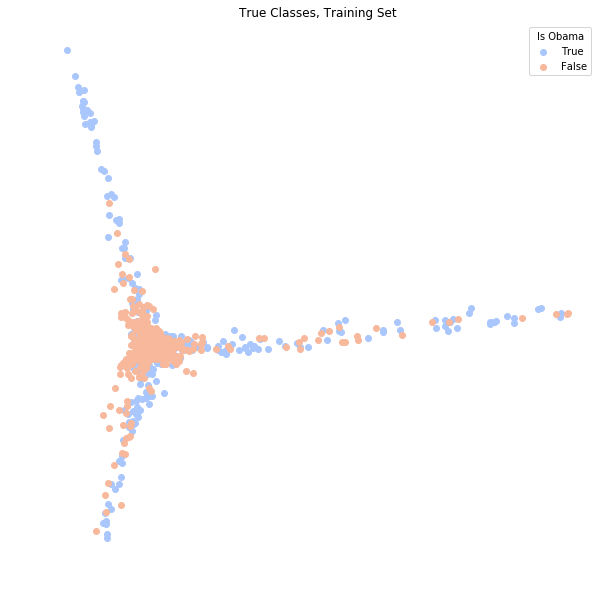

In [13]:
fig, ax = plt.subplots(figsize = (10,10))
ax.axis('off')
pallet = seaborn.color_palette(palette='coolwarm', n_colors = 2)

#Plot Obama
a = np.stack(train_data_df[train_data_df['category']]['pca'])
ax.scatter(a[:,0], a[:, 1], c = pallet[0], label = "True")

#Plot not Obama
a = np.stack(train_data_df[train_data_df['category'].eq(False)]['pca'])
ax.scatter(a[:,0], a[:, 1], c = pallet[1], label = "False")
    
ax.legend(loc = 'upper right', title = 'Is Obama')
plt.title('True Classes, Training Set')
plt.show()

PCA cannot distinguish Obama very well. Let's perform a screeplot to see how many Principal Components we need.

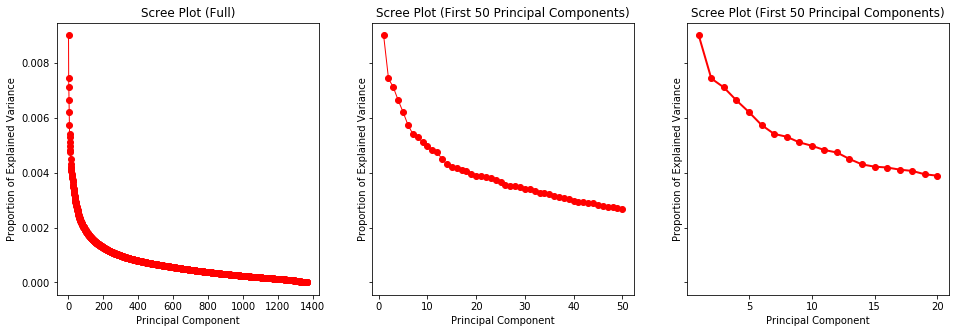

In [14]:
n = len(train_data_df)

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize = (16, 5), sharey=True)

eigen_vals = np.arange(n) + 1
ax1.plot(eigen_vals, pca.explained_variance_ratio_, 'ro-', linewidth=1)
ax1.set_title('Scree Plot (Full)')
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Proportion of Explained Variance')

eigen_vals = np.arange(50) + 1
ax2.plot(eigen_vals, pca.explained_variance_ratio_[:50], 'ro-', linewidth=1)
ax2.set_title('Scree Plot (First 50 Principal Components)')
ax2.set_xlabel('Principal Component')
ax2.set_ylabel('Proportion of Explained Variance')


eigen_vals = np.arange(20) + 1
ax3.plot(eigen_vals, pca.explained_variance_ratio_[:20], 'ro-', linewidth=2)
ax3.set_title('Scree Plot (First 50 Principal Components)')
ax3.set_xlabel('Principal Component')
ax3.set_ylabel('Proportion of Explained Variance')

plt.show()

Let's choose the first 10 pricipal components as our covariates.

In [15]:
train_data_df['pca_reduced_10'] = train_data_df['pca'].apply(lambda x: x[:10])

Now we fit a logistic regression to our data.

In [16]:
logistic = sklearn.linear_model.LogisticRegression()
logistic.fit(np.stack(train_data_df['pca_reduced_10'], axis=0), train_data_df['category'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Let's see how the logistic regression performs on the training dataset from which we develop the model. Unfortunately, the mean accuracy is only about 64%.

In [17]:
logistic.score(np.stack(train_data_df['pca_reduced_10'], axis=0), train_data_df['category'])

0.689327485380117

How does it perform on the testing dataset, which we "held out" and did not use for model training? We need to repeat all the steps on the testing data, but without retraining:

In [18]:
#Create vectors
TFVects_test = TFVectorizer.transform(test_data_df['text'])
test_data_df['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

#PCA
reduced_data_test = pca.transform(np.stack(test_data_df['vect'], axis=0))
test_data_df['pca'] = [r for r in reduced_data_test]
test_data_df['pca_reduced_10'] = test_data_df['pca'].apply(lambda x: x[:10])

#Test
logistic.score(np.stack(test_data_df['pca_reduced_10'], axis=0), test_data_df['category'])

0.6070381231671554

Slightly poorer. How about using more dimensions (40)?

In [19]:
train_data_df['pca_reduced_40'] = train_data_df['pca'].apply(lambda x: x[:40])
test_data_df['pca_reduced_40'] = test_data_df['pca'].apply(lambda x: x[:40])

logistic.fit(np.stack(train_data_df['pca_reduced_40'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_40'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_40'], axis=0), test_data_df['category']))

Training:
0.7404970760233918
Testing:
0.6627565982404692


Or still more (100)?

In [20]:
train_data_df['pca_reduced_100'] = train_data_df['pca'].apply(lambda x: x[:100])
test_data_df['pca_reduced_100'] = test_data_df['pca'].apply(lambda x: x[:100])

logistic.fit(np.stack(train_data_df['pca_reduced_100'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_100'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_100'], axis=0), test_data_df['category']))

Training:
0.8399122807017544
Testing:
0.7448680351906158


Or even more (200)!

In [21]:
train_data_df['pca_reduced_200'] = train_data_df['pca'].apply(lambda x: x[:200])
test_data_df['pca_reduced_200'] = test_data_df['pca'].apply(lambda x: x[:200])

logistic.fit(np.stack(train_data_df['pca_reduced_200'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_200'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_200'], axis=0), test_data_df['category']))

Training:
0.881578947368421
Testing:
0.8035190615835777


This is becoming ridiculous (400)!

In [22]:
train_data_df['pca_reduced_400'] = train_data_df['pca'].apply(lambda x: x[:400])
test_data_df['pca_reduced_400'] = test_data_df['pca'].apply(lambda x: x[:400])

logistic.fit(np.stack(train_data_df['pca_reduced_400'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_400'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_400'], axis=0), test_data_df['category']))

Training:
0.9078947368421053
Testing:
0.8035190615835777


Increasing the number of covariates would overfit our data, and it seems that using a logistic regression, our prediction accuracy is at best about 65%. We can, however, try a logistic regression that uses the TF-IDF scores for each word, but with an L1 regularization or L1-norm loss function, which is also known as least absolute deviations (LAD), least absolute errors (LAE) or L1 penalty. It minimizes the sum of the absolute differences (S) between the target value ($Y_i$) and the estimated values ($f(x_i)$) and prunes all insignificant variables (i.e., word TF-IDF scores):

$S=\sum^n_{i=1}|y_i=f(x_i)|$

The result is a model retaining only the most individually significant features.

In [23]:
logistic_l1= sklearn.linear_model.LogisticRegression(penalty='l1')
logistic_l1.fit(np.stack(train_data_df['vect'], axis=0), train_data_df['category'])
print(logistic_l1.score(np.stack(train_data_df['vect'], axis=0), train_data_df['category']))

0.8530701754385965


Train the model using training data, and then test it on the testing data.

In [24]:
print(logistic_l1.score(np.stack(test_data_df['vect'], axis=0), test_data_df['category']))

0.8357771260997068


81% accuracy seems like the best we can get by using a logistic regression.

Now let's try with Naive Bayes. Classically, it is trained with word counts, but TF-IDF vectors are also quite good:

In [25]:
naiveBayes = sklearn.naive_bayes.BernoulliNB()
naiveBayes.fit(np.stack(train_data_df['vect'], axis=0), train_data_df['category'])

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [26]:
print("Training:")
print(naiveBayes.score(np.stack(train_data_df['vect'], axis=0), train_data_df['category']))
print("Testing:")
print(naiveBayes.score(np.stack(test_data_df['vect'], axis=0), test_data_df['category']))

Training:
0.9678362573099415
Testing:
0.8709677419354839


A bit better than the logit, but that's just looking at the accuracy. What about other measures? Let's first save the predictions in the dataframe to save use rerunning the model every time:

In [27]:
test_data_df['nb_predict'] = naiveBayes.predict(np.stack(test_data_df['vect'], axis=0))
test_data_df['nb_predict_prob_true'] = naiveBayes.predict_proba(np.stack(test_data_df['vect'], axis=0))[:,0] #other is prop false

Precision:

In [29]:
display(test_data_df)

,download_url,html_url,name,path,text,targetSenator,category,tokenized_text,normalized_text,vect,pca,pca_reduced_10,pca_reduced_40,pca_reduced_100,pca_reduced_200,pca_reduced_400,nb_predict,nb_predict_prob_true
965,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,13Dec2007Clinton103.txt,raw/Clinton/13Dec2007Clinton103.txt,December 13 2007 Statement of Senator Clinton...,Clinton,False,"[December, 13, 2007, Statement, of, Senator, C...","[decemb, statement, senat, clinton, passag, en...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.07880485792452545, 0.2962065698096317, 0.1...","[-0.07880485792452545, 0.2962065698096317, 0.1...","[-0.07880485792452545, 0.2962065698096317, 0.1...","[-0.07880485792452545, 0.2962065698096317, 0.1...","[-0.07880485792452545, 0.2962065698096317, 0.1...","[-0.07880485792452545, 0.2962065698096317, 0.1...",True,8.836614e-08
200,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,18Dec2007Obama174.txt,raw/Obama/18Dec2007Obama174.txt,Obama Statement on the Passage of the Omnib...,Obama,True,"[Obama, Statement, on, the, Passage, of, the, ...","[obama, statement, passag, omnibus, spend, pac...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.024600800169206405, -0.015038358533401953,...","[-0.024600800169206405, -0.015038358533401953,...","[-0.024600800169206405, -0.015038358533401953,...","[-0.024600800169206405, -0.015038358533401953,...","[-0.024600800169206405, -0.015038358533401953,...","[-0.024600800169206405, -0.015038358533401953,...",True,1.365890e-02
1579,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,19Dec2007Clinton56.txt,raw/Clinton/19Dec2007Clinton56.txt,December 19 2007 Schumer and Clinton Announce...,Clinton,False,"[December, 19, 2007, Schumer, and, Clinton, An...","[decemb, schumer, clinton, announc, final, sen...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.04241421435462785, -0.0002473729913446158,...","[-0.04241421435462785, -0.0002473729913446158,...","[-0.04241421435462785, -0.0002473729913446158,...","[-0.04241421435462785, -0.0002473729913446158,...","[-0.04241421435462785, -0.0002473729913446158,...","[-0.04241421435462785, -0.0002473729913446158,...",False,1.000000e+00
425,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,26Feb2008Obama142.txt,raw/Obama/26Feb2008Obama142.txt,Durbin Obama Call on President to Provide ...,Obama,True,"[Durbin, Obama, Call, on, President, to, Provi...","[durbin, obama, call, presid, provid, feder, r...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.05397817153371096, -0.16978467318663334, 0...","[-0.05397817153371096, -0.16978467318663334, 0...","[-0.05397817153371096, -0.16978467318663334, 0...","[-0.05397817153371096, -0.16978467318663334, 0...","[-0.05397817153371096, -0.16978467318663334, 0...","[-0.05397817153371096, -0.16978467318663334, 0...",True,2.491900e-18
1195,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,15Mar2005Clinton643.txt,raw/Clinton/15Mar2005Clinton643.txt,March 15 2005 Senator Clinton Meets With New ...,Clinton,False,"[March, 15, 2005, Senator, Clinton, Meets, Wit...","[march, senat, clinton, meet, new, york, fire,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.006640162146886454, -0.014038124905587854,...","[-0.006640162146886454, -0.014038124905587854,...","[-0.006640162146886454, -0.014038124905587854,...","[-0.006640162146886454, -0.014038124905587854,...","[-0.006640162146886454, -0.014038124905587854,...","[-0.006640162146886454, -0.014038124905587854,...",False,1.000000e+00
1062,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,14Apr2005Clinton590.txt,raw/Clinton/14Apr2005Clinton590.txt,April 14 2005 Clinton Calls on President to A...,Clinton,False,"[April, 14, 2005

In [28]:
sklearn.metrics.precision_score(test_data_df['nb_predict'], test_data_df['category'])

0.8590604026845637

Recall:

In [ ]:
sklearn.metrics.recall_score(test_data_df['nb_predict'], test_data_df['category'])

F1-measure:

In [ ]:
sklearn.metrics.f1_score(test_data_df['nb_predict'], test_data_df['category'])

Let's take a look at how well our posterior distribution looks relative to the truth.

In [ ]:
fig, ax = plt.subplots()
ax.grid(False)
ax.set_frame_on(False)
test_data_df[test_data_df['category'].eq(True)]['nb_predict_prob_true'].hist(alpha = 0.5, ax = ax, bins = 10, label = 'True', color = 'red')
test_data_df[test_data_df['category'].eq(False)]['nb_predict_prob_true'].hist(alpha = 0.5, ax = ax, bins = 10, label = 'False', color = 'blue')
ax.set_xlim((0,1.1))
ax.legend(title = "Is Obama")
ax.set_xlabel('posterior')
ax.set_ylabel('counts')
plt.show()

The classification is suprisingly accurate. We can even look at what words are most influential with a bit of simple math:

In [ ]:
#Top indices
trueVals, falseVals = naiveBayes.feature_log_prob_

words_dict = {
    'Obama' : [],
    'Obama_log_prob' : [],
    'Clinton' : [],
    'Clinton_log_prob' : [],
}

for i, prob in sorted(enumerate(trueVals), key = lambda x:x[1], reverse=True)[:15]:
    words_dict['Obama'].append(TFVectorizer.get_feature_names()[i])
    words_dict['Obama_log_prob'].append(prob)

for i, prob in sorted(enumerate(falseVals), key = lambda x:x[1], reverse=True)[:15]:
    words_dict['Clinton'].append(TFVectorizer.get_feature_names()[i])
    words_dict['Clinton_log_prob'].append(prob)
    
pandas.DataFrame(words_dict)

## Multinomial Naive Bayes

What if we want to classify our text into one of *many* classes? The multinomial Naive Bayes generating model assumes that document features (e.g., words) are generated by draws from a multinomial distribution (recall this gives the probability to observe a particular pattern of counts across features). 

Let's use again the dataset we used in week 3, the 20 newsgroup dataset.

In [ ]:
newsgroups = sklearn.datasets.fetch_20newsgroups(data_home = '../data') #Free data to play with: documents from a newsgroup corpus.
newsgroups.target_names #Possible categories, i.e., the newsgroups

We can pick specific categories, and pull the relevant training and testing sets. 

In [ ]:
target_categories = ['talk.religion.misc', 'soc.religion.christian', 'sci.space', 'comp.graphics'] #Can change these of course

newsgroupsDF = pandas.DataFrame(columns = ['text', 'category', 'source_file'])
for category in target_categories:
    print("Loading data for: {}".format(category))
    ng = sklearn.datasets.fetch_20newsgroups(categories = [category], remove=['headers', 'footers', 'quotes'], data_home = '../data')
    newsgroupsDF = newsgroupsDF.append(pandas.DataFrame({'text' : ng.data, 'category' : [category] * len(ng.data), 'source_file' : ng.filenames}), ignore_index=True)

Now we need to tokenize, and make a training and testing set:

In [ ]:
newsgroupsDF['tokenized_text'] = newsgroupsDF['text'].apply(lambda x: nltk.word_tokenize(x))
newsgroupsDF['normalized_text'] = newsgroupsDF['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x, stopwordLst = lucem_illud.stop_words_basic, stemmer = lucem_illud.stemmer_basic))

In [ ]:
holdBackFraction = .2
train_ng_df, test_ng_df = lucem_illud.trainTestSplit(newsgroupsDF, holdBackFraction=holdBackFraction)

In [ ]:
print(len(train_ng_df))
print(len(test_ng_df))

We need to extract features from the text. We can use built-in feature extraction to do so. We will use a tf-idf vectorizer, which converts the document into a vector of words with tf-idf weights (term-frequency inverse-document frequency). This gives high weight to words that show up a lot in a given document, but rarely across documents in the corpus (more distinctive). 

In [ ]:
TFVectorizer_ng = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects_ng = TFVectorizer_ng.fit_transform(train_ng_df['text'])
train_ng_df['vect'] = [np.array(v).flatten() for v in TFVects_ng.todense()]

Now we can train the model:

In [ ]:
MultinomialNB_ng = sklearn.naive_bayes.MultinomialNB()
MultinomialNB_ng.fit(np.stack(train_ng_df['vect'], axis = 0), train_ng_df['category'])

...and save predictions to the dataframe:

In [ ]:
train_ng_df['nb_predict'] = MultinomialNB_ng.predict(np.stack(train_ng_df['vect'], axis=0))
print("Training score:")
print(MultinomialNB_ng.score(np.stack(train_ng_df['vect'], axis=0), train_ng_df['category']))

In [ ]:
train_ng_df[['category', 'nb_predict']][:10]

Looks pretty good, lets examine the testing dataset:

In [ ]:
#Create vectors
TFVects_test = TFVectorizer_ng.transform(test_ng_df['text'])
test_ng_df['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

#Add to df
test_ng_df['nb_predict'] = MultinomialNB_ng.predict(np.stack(test_ng_df['vect'], axis=0))

#Test
print("Testing score:")
print(MultinomialNB_ng.score(np.stack(test_ng_df['vect'], axis=0), test_ng_df['category']))

We can even use a confusion matrix, like we used last week for evaluating human coders relative to one another. Now we are evaluating our classifier relative to human coding. We'll just use the one in `lucem_illud`, which requres a classifier and a dataframe with `'vect'` and `'category'` columns, like we have in the examples:

In [ ]:
lucem_illud.plotConfusionMatrix(MultinomialNB_ng, test_ng_df)

Let's calculate the precision, recall, and F-measures.

In [ ]:
print(sklearn.metrics.precision_score(test_ng_df['nb_predict'], test_ng_df['category'], average = 'weighted')) #precision
print(sklearn.metrics.recall_score(test_ng_df['nb_predict'], test_ng_df['category'], average = 'weighted')) #recall
print(sklearn.metrics.f1_score(test_ng_df['nb_predict'], test_ng_df['category'], average = 'weighted')) #F-1 measure

We can evaluate these per catagory. This has the same requiments as `plotConfusionMatrix`:

In [ ]:
lucem_illud.metrics.evaluateClassifier(MultinomialNB_ng, test_ng_df)

We can also plot the ROC curves. This has the same requiments as `plotConfusionMatrix`:

In [ ]:
lucem_illud.plotMultiROC(MultinomialNB_ng, test_ng_df)

And we can plot the PCA space visualization:

In [ ]:
lucem_illud.plotregions(MultinomialNB_ng, test_ng_df)

We can also give the model a new string, not present in our data, and use the *predict* method to see if it can assign it to a category. Using our model to extend its classifications to new, uncoded data might be the primary purpose of a social science application. The words do have to be in the vocabulary, so don't be too creative :-)

In [ ]:
def predict_category(s, model, tfidf): #We just define a simple function here
    a = np.zeros((1, len(tfidf.vocabulary_)))
    for w in nltk.word_tokenize(s):
        try:
            a[:,tfidf.vocabulary_[lucem_illud.stemmer_basic.stem(w.lower())]] = 1
        except KeyError:
            print("Warning: '{}' not in vocabulary".format(w))
    return model.predict(a)[0]

In [ ]:
predict_category('rockets are cool', MultinomialNB_ng, TFVectorizer_ng)

## <span style="color:red">*Exercise 2*</span>

<span style="color:red">In the cells immediately following, perform Logistic and Naïve Bayes classification (binary or multinomial) using training, testing and extrapolation (uncoded) data from texts and hand-classifications associated with your final project (e.g., these could be crowd-sourced codes gathered through Amazon Mechanical Turk last week). Visualize the confusion matrix for training and testing sets. Calculate precision, recall, the F-measure, and AUC, then perform an ROC visualization. How do these classifiers perform? Exrapolate codes from these models to all uncoded data.


In [ ]:
# data prep

In [ ]:
powMIA = pandas.read_csv("../data/powMIA.csv")

In [ ]:
# create new variable
# originally, I created a binomial variable called 'prisoner', but a lot of 
# the lucem illud functions want a variable called 'category', so we're gonna
# make that instead

powMIA['prisoner'] = [s == 2 for s in powMIA['cluster']]
powMIA['category'] = [s == 2 for s in powMIA['cluster']]

In [ ]:
# looks like 73/393 of my articles are coded as referencing prisoners. 

print(len(powMIA))
print(powMIA[powMIA == True].count())

In [ ]:
powMIA['tokenizedArticle'] = powMIA['article'].apply(lambda x: nltk.word_tokenize(x))
powMIA['normalizedArticle'] = powMIA['tokenizedArticle'].apply(lambda x: lucem_illud.normalizeTokens(x, stopwordLst = lucem_illud.stop_words_basic, stemmer = lucem_illud.stemmer_basic))

In [ ]:
print(powMIA)

In [ ]:
holdBackFraction = .2
train_data_df, test_data_df = lucem_illud.trainTestSplit(powMIA, holdBackFraction=holdBackFraction)

In [ ]:
print(len(train_data_df))

In [ ]:
print(len(test_data_df))

In [ ]:
# logistic regression

In [ ]:
TFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')

TFVects = TFVectorizer.fit_transform(train_data_df['article'])

In [ ]:
TFVects.shape

In [ ]:
train_data_df['vect'] = [np.array(v).flatten() for v in TFVects.todense()]

In [ ]:
pca = sklearn.decomposition.PCA()
reduced_data = pca.fit_transform(np.stack(train_data_df['vect'], axis=0))

In [ ]:
train_data_df['pca'] = [r for r in reduced_data]

In [ ]:
#Viualize
fig, ax = plt.subplots(figsize = (10,10))
ax.axis('off')
pallet = seaborn.color_palette(n_colors = 2)

#plot POW
a = np.stack(train_data_df[train_data_df['category']]['pca'])
ax.scatter(a[:,0], a[:, 1], c = pallet[0], label = "True")

#Plot No Social
a = np.stack(train_data_df[train_data_df['category'].eq(False)]['pca'])
ax.scatter(a[:,0], a[:, 1], c = pallet[1], label = "False")
    
ax.legend(loc = 'upper right', title = 'Mentions POWs')
plt.title('True Classes, Training Set')
plt.show()

In [ ]:
n = len(train_data_df)

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize = (16, 5), sharey=True)

eigen_vals = np.arange(n) + 1
ax1.plot(eigen_vals, pca.explained_variance_ratio_, 'ro-', linewidth=1)
ax1.set_title('Scree Plot (Full)')
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Proportion of Explained Variance')

eigen_vals = np.arange(40) + 1
ax2.plot(eigen_vals, pca.explained_variance_ratio_[:40], 'ro-', linewidth=1)
ax2.set_title('Scree Plot (First 40 Principal Components)')
ax2.set_xlabel('Principal Component')
ax2.set_ylabel('Proportion of Explained Variance')


eigen_vals = np.arange(20) + 1
ax3.plot(eigen_vals, pca.explained_variance_ratio_[:20], 'ro-', linewidth=2)
ax3.set_title('Scree Plot (First 20 Principal Components)')
ax3.set_xlabel('Principal Component')
ax3.set_ylabel('Proportion of Explained Variance')

plt.show()

In [ ]:
# going to stick to first 10 PCA as covariates
train_data_df['pca_reduced_10'] = train_data_df['pca'].apply(lambda x: x[:10])

In [ ]:
# and now fit a regression

logistic = sklearn.linear_model.LogisticRegression()
logistic.fit(np.stack(train_data_df['pca_reduced_10'], axis=0), train_data_df['prisoner'])

In [ ]:
# not terrible 

logistic.score(np.stack(train_data_df['pca_reduced_10'], axis=0), train_data_df['prisoner'])

In [ ]:
# what about on the test data?
# about the same

#Create vectors
TFVects_test = TFVectorizer.transform(test_data_df['article'])
test_data_df['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

#PCA
reduced_data_test = pca.transform(np.stack(test_data_df['vect'], axis=0))
test_data_df['pca'] = [r for r in reduced_data_test]
test_data_df['pca_reduced_10'] = test_data_df['pca'].apply(lambda x: x[:10])

#Test
logistic.score(np.stack(test_data_df['pca_reduced_10'], axis=0), test_data_df['prisoner'])

In [ ]:
# on all the data - about as well as the test set. 

#Create vectors
TFVects_test = TFVectorizer.transform(powMIA['article'])
powMIA['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

#PCA
reduced_data_test = pca.transform(np.stack(powMIA['vect'], axis=0))
powMIA['pca'] = [r for r in reduced_data_test]
powMIA['pca_reduced_10'] = powMIA['pca'].apply(lambda x: x[:10])

#Test
logistic.score(np.stack(powMIA['pca_reduced_10'], axis=0), powMIA['prisoner'])

In [ ]:
# now with tf-idf, and better!

logistic_l1= sklearn.linear_model.LogisticRegression(penalty='l1')
logistic_l1.fit(np.stack(train_data_df['vect'], axis=0), train_data_df['prisoner'])
print(logistic_l1.score(np.stack(train_data_df['vect'], axis=0), train_data_df['prisoner']))

In [ ]:
# back to pretty mediocre

print(logistic_l1.score(np.stack(test_data_df['vect'], axis=0), test_data_df['prisoner']))


In [ ]:
# Naive Bayes

In [ ]:
naiveBayes = sklearn.naive_bayes.BernoulliNB()
naiveBayes.fit(np.stack(train_data_df['vect'], axis=0), train_data_df['prisoner'])

In [ ]:
print("Training:")
print(naiveBayes.score(np.stack(train_data_df['vect'], axis=0), train_data_df['prisoner']))
print("Testing:")
print(naiveBayes.score(np.stack(test_data_df['vect'], axis=0), test_data_df['prisoner']))

In [ ]:
test_data_df['nb_predict'] = naiveBayes.predict(np.stack(test_data_df['vect'], axis=0))
test_data_df['nb_predict_prob_true'] = naiveBayes.predict_proba(np.stack(test_data_df['vect'], axis=0))[:,0] 

In [ ]:
print("precision:")
print(sklearn.metrics.precision_score(test_data_df['nb_predict'], test_data_df['prisoner']))

In [ ]:
print("recall:")
print(sklearn.metrics.recall_score(test_data_df['nb_predict'], test_data_df['prisoner']))

In [ ]:
print("f1:")
print(sklearn.metrics.f1_score(test_data_df['nb_predict'], test_data_df['prisoner'])
)

In [ ]:
#posterior distributions
fig, ax = plt.subplots()
ax.grid(False)
ax.set_frame_on(False)
test_data_df[test_data_df['prisoner'].eq(True)]['nb_predict_prob_true'].hist(alpha = 0.5, ax = ax, bins = 10, label = 'True', color = 'red')
test_data_df[test_data_df['prisoner'].eq(False)]['nb_predict_prob_true'].hist(alpha = 0.5, ax = ax, bins = 10, label = 'False', color = 'blue')
ax.set_xlim((0,1.1))
ax.legend(title = "Mention of POWs")
ax.set_xlabel('posterior')
ax.set_ylabel('counts')
plt.show()

In [ ]:
# looks like performance is mixed, and maybe overfit considering recall is 1
# let's look at some word predictions and see if they make any sense

trueVals, falseVals = naiveBayes.feature_log_prob_

words_dict = {
    'POWs mentioned' : [],
    'pow_log_prob' : [],
    'No POWs mentioned' : [],
    'noPOW_log_prob' : [],
}

for i, prob in sorted(enumerate(trueVals), key = lambda x:x[1], reverse=True)[:15]:
    words_dict['No POWs mentioned'].append(TFVectorizer.get_feature_names()[i])
    words_dict['noPOW_log_prob'].append(prob)

for i, prob in sorted(enumerate(falseVals), key = lambda x:x[1], reverse=True)[:15]:
    words_dict['POWs mentioned'].append(TFVectorizer.get_feature_names()[i])
    words_dict['pow_log_prob'].append(prob)
    
pandas.DataFrame(words_dict)

In [ ]:
clf_nn = sklearn.neural_network.MLPClassifier()
clf_nn.fit(np.stack(train_data_df['vect'], axis=0), train_data_df['category'])

In [ ]:
lucem_illud.plotConfusionMatrix(naiveBayes, test_data_df)

In [ ]:
lucem_illud.plotMultiROC(naiveBayes, train_data_df)

# Decision Trees

Decision trees can be used to predict both categorical/class labels (i.e., classification) and continuous labels (i.e., regression).

In [ ]:
blobs_df = lucem_illud.multiBlobs(noise=.2, centers=[(0,0), (0,5), (5,0), (-5,0), (0,-5)])
df_exampleTree_train, df_exampleTree_test = lucem_illud.trainTestSplit(blobs_df)
lucem_illud.plotter(df_exampleTree_train)

Now we import our Decision Tree classifier from sklearn.tree (familiar syntax) and fit it using the fit method.

In [ ]:
clf_tree = sklearn.tree.DecisionTreeClassifier(max_depth=4,random_state=0)
clf_tree.fit(np.stack(df_exampleTree_train['vect'], axis =0), df_exampleTree_train['category'])

To see what's going on visually with the classification: 

In [ ]:
lucem_illud.plotregions(clf_tree, df_exampleTree_train)

In [ ]:
lucem_illud.evaluateClassifier(clf_tree, df_exampleTree_test)

Lets look at accuracy:

In [ ]:
sklearn.metrics.accuracy_score(df_exampleTree_test['category'],clf_tree.predict(np.stack(df_exampleTree_test['vect'], axis = 0)))

What happens if we trim the tree?

In [ ]:
depthvec = []
scorevec = []
for i in range(1,20):
    tree2 = sklearn.tree.DecisionTreeClassifier(max_depth=i,random_state=0)
    tree2.fit(np.stack(df_exampleTree_train['vect'], axis =0), df_exampleTree_train['category'])
    score = sklearn.metrics.accuracy_score(df_exampleTree_test['category'], tree2.predict(np.stack(df_exampleTree_test['vect'], axis = 0)))
    depthvec.append(i)
    scorevec.append(score)
plt.scatter(depthvec,scorevec)
plt.show()

We can select different layers of the decision tree or "prune" it. At approximately four layers down in the decision tree, the shape is somewhat odd, suggesting that our model is overfitting beyond those four layers.

Combining multiple overfitting estimators turns out to be a key idea in machine learning. This is called **bagging** and is a type of **ensemble** method. The idea is to make many randomized estimators--each can overfit, as decision trees are wont to do--but then to combine them, ultimately producing a better classification. A **random forest** is produced by bagging decision trees.

In [ ]:
tree = sklearn.tree.DecisionTreeClassifier(max_depth=10) #Create an instance of our decision tree classifier.

bag = sklearn.ensemble.BaggingClassifier(tree, n_estimators=100, max_samples=0.8, random_state=1) #Each tree uses up to 80% of the data

In [ ]:
bag.fit(np.stack(df_exampleTree_train['vect'], axis =0), df_exampleTree_train['category']) #Fit the bagged classifier

In [ ]:
lucem_illud.plotregions(bag, df_exampleTree_test)

In [ ]:
lucem_illud.evaluateClassifier(bag, df_exampleTree_test)

In [ ]:
lucem_illud.plotConfusionMatrix(bag, df_exampleTree_test)

## <span style="color:red">*Exercise 3*</span>

<span style="color:red">In the cells immediately following, perform decision tree and random forest classification (binary, multinomial or continuous) using training, testing and extrapolation (uncoded) data from texts and hand-classifications associated with your final project. As with ***Exercise 2***, these could be crowd-sourced codes gathered through Amazon Mechanical Turk last week. Visualize the classification of data points. Calculate relevant metrics (e.g., precision, recall, the F-measure, and AUC). Now build an ensemble classifier by bagging trees into a random forest. Visualize the result. How do these classifiers perform? What does ensemble learning do?

In [ ]:
#data prep

TFVects = TFVectorizer.transform(powMIA['article'])
powMIA['vect'] = [np.array(v).flatten() for v in TFVects.todense()]

# split 
holdBackFraction = .2
trainData, testData = lucem_illud.trainTestSplit(powMIA, holdBackFraction=holdBackFraction)


In [ ]:
# decision tree

In [ ]:
powTree = sklearn.tree.DecisionTreeClassifier(max_depth=4,random_state=0)
powTree.fit(np.stack(trainData['vect'], axis =0), trainData['prisoner'])

In [ ]:
# not looking too good for me!

lucem_illud.plotregions(powTree, train_data_df)

In [ ]:
testData['category'] = testData['prisoner']
lucem_illud.evaluateClassifier(powTree, testData)

In [ ]:
sklearn.metrics.accuracy_score(testData['category'],powTree.predict(np.stack(testData['vect'], axis = 0)))

In [ ]:
# random forest

In [ ]:
tree = sklearn.tree.DecisionTreeClassifier(max_depth=10)

bag = sklearn.ensemble.BaggingClassifier(tree, n_estimators=100, max_samples=0.8, random_state=1) 

In [ ]:
# since my original dataset actually has 4 pseudo-topics, let's unleash this thing on all 4

bag.fit(np.stack(trainData['vect'], axis =0), trainData['prisoner'])

In [ ]:
lucem_illud.plotregions(bag, testData)

In [ ]:
lucem_illud.evaluateClassifier(bag,testData)

In [ ]:
lucem_illud.plotConfusionMatrix(bag, testData)

# K-Nearest Neighbors

The K-Nearest neighbors classifier takes a simpler premise than those before: Find the closest labeled datapoint in set and "borrow" its label.

Let's use newsgroup data again.

In [ ]:
newsgroupsDF[:5]

Make a testing and training set:

In [ ]:
holdBackFraction = .2
train_ng_df, test_ng_df = lucem_illud.trainTestSplit(newsgroupsDF, holdBackFraction=holdBackFraction)

Let's initialize our k-nearest neighbors classifier:

In [ ]:
n_neighbors = 15
weights="uniform"
clf_knearest = sklearn.neighbors.KNeighborsClassifier(n_neighbors, weights=weights)

Let's try to classify using the TF-IDF vectors:

In [ ]:
TFVectorizer_ng = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects_ng = TFVectorizer_ng.fit_transform(train_ng_df['text'])
train_ng_df['vect'] = [np.array(v).flatten() for v in TFVects_ng.todense()]

In [ ]:
clf_knearest.fit(np.stack(train_ng_df['vect'], axis = 0), train_ng_df['category'])

In [ ]:
lucem_illud.evaluateClassifier(clf_knearest, train_ng_df)

And lets look at the testing data

In [ ]:
#Create vectors
TFVects_test = TFVectorizer_ng.transform(test_ng_df['text'])
test_ng_df['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

#Add to df
test_ng_df['nb_predict'] = clf_knearest.predict(np.stack(test_ng_df['vect'], axis=0))

#Test
print("Testing score:")
print(clf_knearest.score(np.stack(test_ng_df['vect'], axis=0), test_ng_df['category']))

Let's produce another confusion matrix:

In [ ]:
lucem_illud.plotConfusionMatrix(clf_knearest, test_ng_df)

You can produce the PCA space visual if you want, altough it can take a very long time, so we'll leave it optionally commented out:

In [ ]:
#lucem_illud.plotregions(clf_knearest, test_ng_df)

## <span style="color:red">*Exercise 4*</span>

<span style="color:red">In the cells immediately following, perform and visualize k-nearest neighbor classification using training, testing and extrapolation (uncoded) data from texts and hand-classifications associated with your final project. Visualize the classification of data points and calculate relevant metrics (e.g., precision, recall, the F-measure, and AUC). Articulate how the *k*-nearest neighbor approach relates to *k*-means clustering explored in ***week 3***?

In [ ]:
# data...PREP!!

holdBackFraction = .2
dataTest, dataTrain = lucem_illud.trainTestSplit(powMIA, holdBackFraction=holdBackFraction)

In [ ]:
# I'll stick with the example n_neighbors (15) and see what comes out

n_neighbors = 15
weights="uniform"
clf_knearest = sklearn.neighbors.KNeighborsClassifier(n_neighbors, weights=weights)

In [ ]:
# a-vect'ing, all over again

TFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects = TFVectorizer.fit_transform(dataTrain['article'])
dataTrain['vect'] =  [np.array(v).flatten() for v in TFVects.todense()]

In [ ]:
clf_knearest.fit(np.stack(dataTrain['vect'], axis = 0), dataTrain['category'])

In [ ]:
lucem_illud.evaluateClassifier(clf_knearest, dataTrain)

In [ ]:
# to test

TFVects_test = TFVectorizer.transform(dataTest['article'])
dataTest['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

dataTest['nb_predict'] = clf_knearest.predict(np.stack(dataTest['vect'], axis=0))

#Test
print("Testing score:")
print(clf_knearest.score(np.stack(dataTest['vect'], axis=0), dataTest['category']))

In [ ]:
# let's visualize on my test data

lucem_illud.plotConfusionMatrix(clf_knearest, dataTest)

# SVMs

Now we will examine Support Vector Machines, an approach that creates the partition that preserves the "maximum margin" between classes.

We will use a few sub forums from reddit--which tend to share text rather than memes--namely `talesfromtechsupport`, `badroommates`, `weeabootales` and `relationships`. The top 100 text posts from each have been saved to `data/reddit.csv`.

In [ ]:
redditDf = pandas.read_csv('../data/reddit.csv', index_col = 0)

#Drop a couple missing values

redditDf = redditDf.dropna()

#Set category

redditDf['category'] = redditDf['subreddit']

#tokenize and normalize
redditDf['tokenized_text'] = redditDf['text'].apply(lambda x: nltk.word_tokenize(x))
redditDf['normalized_text'] = redditDf['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x, stopwordLst = lucem_illud.stop_words_basic, stemmer = lucem_illud.stemmer_basic))

We will tf.idf the data to make our vectors:

In [ ]:
redditTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, min_df=3, stop_words='english', norm='l2')
redditTFVects = redditTFVectorizer.fit_transform([' '.join(l) for l in redditDf['normalized_text']])
redditDf['vect'] = [np.array(v).flatten() for v in redditTFVects.todense()]

Initilize the model and make a train test split:

In [ ]:
holdBackFraction = .2
train_redditDf, test_redditDf = lucem_illud.trainTestSplit(redditDf, holdBackFraction=holdBackFraction)

In [ ]:
clf_svm = sklearn.svm.SVC(kernel='linear', probability = False)
#probability = True is slower but  lets you call predict_proba()
clf_svm.fit(np.stack(train_redditDf['vect'], axis=0), train_redditDf['category'])

...and consider the results:

In [ ]:
lucem_illud.evaluateClassifier(clf_svm, test_redditDf)

In [ ]:
lucem_illud.plotConfusionMatrix(clf_svm, test_redditDf)

In [ ]:
lucem_illud.plotregions(clf_svm, test_redditDf)

# Neural Nets

We include an example of a simple neural network, the Multi-layer Perceptron (MLP) that learns a function $f(\cdot): R^m \rightarrow R^o$ by training on a dataset, where $m$ is the number of dimensions for input and $o$ is the number of dimensions for output. Given a set of features $X = {x_1, x_2, ..., x_m}$ and a target $y$, it can learn a non-linear function approximator for either classification or regression. It is different from logistic regression, in that between the input and the output layer, there can be one or more non-linear layers, called hidden layers. The following figure shows a one hidden layer MLP with scalar output. ![title](../data/multilayerperceptron_network.png) The leftmost layer, known as the input layer, consists of a set of "neurons" $\{x_i | x_1, x_2, ..., x_m\}$ representing the input features (e.g., weighted words). Each neuron in the hidden layer transforms the values from the previous layer with a weighted linear summation $w_1x_1 + w_2x_2 + ... + w_mx_m$, followed by a non-linear activation function $g(\cdot):R \rightarrow R$ - like the logistic or hyperbolic tan function. The output layer receives the values from the last hidden layer and transforms them into output values.

In [ ]:
clf_nn = sklearn.neural_network.MLPClassifier()
clf_nn.fit(np.stack(train_redditDf['vect'], axis=0), train_redditDf['category'])

In [ ]:
lucem_illud.evaluateClassifier(clf_nn, test_redditDf)

In [ ]:
lucem_illud.plotConfusionMatrix(clf_nn, test_redditDf)

In [ ]:
lucem_illud.plotregions(clf_nn, test_redditDf)

It performs very well.

## <span style="color:red">*Exercise 5*</span>

<span style="color:red">In the cells immediately following, perform a neural network classification and calculate relevant metrics (e.g., precision, recall, the F-measure, and AUC). How does this classify relevant to *k*-nearest neighbor, Naive Bayes, logistic and decision-tree approaches?

In [ ]:
clf_nn.fit(np.stack(dataTrain['vect'], axis=0), dataTrain['category'])

In [ ]:
dataTest['nb_predict'] = clf_nn.predict(np.stack(dataTest['vect'], axis=0))

In [ ]:
#precision!

sklearn.metrics.precision_score(dataTest['nb_predict'], dataTest['category'])

In [ ]:
# recall!
sklearn.metrics.recall_score(dataTest['nb_predict'], dataTest['category'])

In [ ]:
# f1!

sklearn.metrics.f1_score(dataTest['nb_predict'], dataTest['category'])

In [ ]:
lucem_illud.plotConfusionMatrix(clf_nn, dataTest)

In [ ]:
lucem_illud.plotConfusionMatrix(clf_nn, dataTrain)

In [ ]:
lucem_illud.plotregions(clf_nn, dataTest)

In [ ]:
lucem_illud.plotregions(clf_nn, dataTrain)